In [ ]:
# # setup for the colab
# !pip install imageio
# !pip install torch
# !pip install kaggle
# # upload kaggle.json for data downloading
# from google.colab import files
# files.upload()
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c tgs-salt-identification-challenge
# !mkdir -p test
# !mkdir -p train
# !unzip test.zip -d test
# !unzip train.zip -d train

In [ ]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize

In [ ]:
HEIGHT, WIDTH = 101, 101

In [ ]:
root_path = './'
train_path = os.path.join(root_path, "train")

def get_image(file_id):
    image_path = os.path.join(train_path, "images", file_id + '.png')
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    return image

def get_mask(file_id):
    mask_path = os.path.join(train_path, "masks", file_id + '.png')
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
    return mask


In [ ]:
train_values = pd.read_csv('train.csv')
file_list = list(train_values['id'])

In [ ]:
def rle_to_mask(rle_string):
    if isinstance(rle_string, float) and np.isnan(rle_string):
        return np.zeros((HEIGHT, WIDTH)) 
    rle_numbers = [int(num) for num in rle_string.split()] 
    rle_pairs = np.array(rle_numbers).reshape((-1, 2))
    
    mask = np.zeros(HEIGHT*WIDTH)
    for start, length in rle_pairs:
        mask[start-1: start-1+length] = 255
    
    mask = mask.reshape((HEIGHT, WIDTH)).T
        
    return mask


In [ ]:
# check if masks correctly oriented
for _ in range(15):
    i = random.randint(0, len(dataset)-1) 
    file_id = file_list[i]
    image, mask = get_image(file_id), get_mask(file_id)
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(rle_to_mask(train_values['rle_mask'][i]), cmap='gray')
    print(i, 'is correct: ', (mask==rle_to_mask(train_values['rle_mask'][i])).all())
    

In [ ]:
pixels = float(HEIGHT*WIDTH)
depths = pd.read_csv("depths.csv")

train_values['depths'] = depths['z']

plt.figure(figsize=(6, 6))
plt.hist(train_values['depths'], bins=50)


In [ ]:
norm = HEIGHT * WIDTH * 255.0
def salt_concentration(mask):
    return np.sum(mask)/norm

masks = [get_mask(file_id) for file_id in train_values['id']]
train_values['salt_concentration'] = [salt_concentration(mask) for mask in masks]

In [ ]:
train_val = train_values.merge(depths, how='left')

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(train_val['salt_concentration'], train_val['depths'])
plt.title("Depths vs salt concentration")

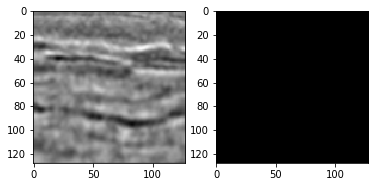

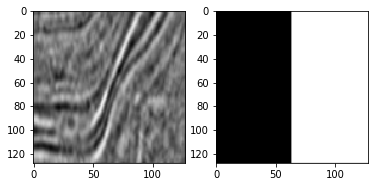

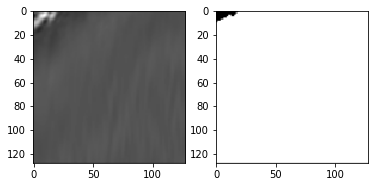

In [499]:
# what to do
# postprocess
# dropout
# pycharm
# model saving

im_resize = (128, 128)

def get_resize(img):
    return resize(img, im_resize, mode='constant', anti_aliasing=False)

for i, file_id in enumerate(file_list[:3]):
    image = get_resize(get_image(file_id))
    mask = get_resize(get_mask(file_id))
    _, axarr = plt.subplots(1, 2)
    
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')


In [511]:
from keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D, concatenate
from keras.models import Model

def salt_detector():
    common_atr = {'activation': 'relu', 'padding': 'same'}
    
    input_image = Input(shape=(101, 101, 1))
    conv1 = Conv2D(64, (3, 3), **common_atr)(input_image)
    conv1 = Conv2D(64, (3, 3), **common_atr)(conv1)
    max1 = MaxPooling2D((2, 2), padding='same')(conv1)
    
    conv2 = Conv2D(32, (3, 3), **common_atr)(max1)
    conv2 = Conv2D(32, (3, 3), **common_atr)(conv2)
    max2 = MaxPooling2D((2, 2), padding='same')(conv2)
    
    conv3 = Conv2D(32, (3, 3), **common_atr)(max2)
    conv3 = Conv2D(32, (3, 3), **common_atr)(conv3)
    encoded = MaxPooling2D((2, 2), padding='same')(conv3)
    
    conv10 = Conv2D(32, (3, 3), **common_atr)(encoded)
    conv10 = Conv2D(32, (3, 3), **common_atr)(conv10)
    up10 = UpSampling2D((2, 2))(conv10)
    
    conv11 = Conv2D(32, (3, 3), **common_atr)(up10)
    conv11 = Conv2D(32, (3, 3), **common_atr)(conv11)
    up11 = UpSampling2D((2, 2))(conv11)
    
    conv12 = Conv2D(64, (3, 3), **common_atr)(up11)
    conv12 = Conv2D(64, (3, 3), **common_atr)(conv12)
    up12 = UpSampling2D((2, 2))(conv12)
    
    conv13 = conv12 = Conv2D(64, (3, 3), **common_atr)(up12)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv13)
    
    autoencoder = Model(input_image, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

detector = salt_detector()
detector.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 101, 101, 1)       0         
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 101, 101, 64)      640       
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 101, 101, 64)      36928     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 51, 51, 32)        18464     
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 51, 51, 32)        9248      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 26, 26, 32)        0         
__________

In [502]:
def prepare(images):
    images = np.stack(images)
    images = images[:, :, :, :1].astype('float32') / 255.
    return images

In [ ]:
labels = prepare([get_mask(file_id)[:,:,np.newaxis] for file_id in file_list])
images = prepare([get_image(file_id) for file_id in file_list])

In [510]:
mask = np.reshape(get_mask(file_list[2]), (101, 101, 1))
mask_ = mask.astype('float32')/255.
mask_
resize(mask_, im_resize, mode='constant', anti_aliasing=True)

# prepare([])

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.89453125],
        [0.89453125],
        [0.80018616]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.        ],
        [1.        ],
        [0.89453125]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [1.        ],
        [1.        ],
        [0.89453125]],

       ...,

       [[0.89453125],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [0.89453125]],

       [[0.89453125],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [0.89453125]],

       [[0.80018616],
        [0.89453125],
        [0.89453125],
        ...,
        [0.89453125],
        [0.89453125],
        [0.80018616]]])

In [463]:
val_size = 512
images_train, images_val = images[:-val_size], images[-val_size:]
labels_train, labels_val = labels[:-val_size], labels[-val_size:]

In [462]:
detector.fit(images_train, labels_train, epochs=1, batch_size=128, shuffle=True, validation_data=(images_val, labels_val) )

Train on 3872 samples, validate on 128 samples
Epoch 1/1
3872/3872 [==============================] - 332s 86ms/step - loss: 0.2011 - val_loss: 0.0117


In [469]:
print(detector.predict(images[2:3])*255)


[[[[63.595055 ]
   [35.383156 ]
   [24.18307  ]
   ...
   [26.57798  ]
   [40.054653 ]
   [68.931015 ]]

  [[41.203415 ]
   [14.306161 ]
   [ 7.5871973]
   ...
   [ 8.565992 ]
   [16.72677  ]
   [45.197533 ]]

  [[30.376505 ]
   [ 7.7623806]
   [ 3.366054 ]
   ...
   [ 3.814394 ]
   [ 9.074765 ]
   [33.120705 ]]

  ...

  [[35.460083 ]
   [10.096604 ]
   [ 4.6065946]
   ...
   [ 4.4432745]
   [ 9.641839 ]
   [33.314003 ]]

  [[49.48971  ]
   [19.463835 ]
   [10.969433 ]
   ...
   [10.365628 ]
   [17.86202  ]
   [45.635376 ]]

  [[80.08678  ]
   [52.82645  ]
   [40.722725 ]
   ...
   [39.399284 ]
   [50.309834 ]
   [77.81459  ]]]]


In [477]:

print(labels[2]*255)
# for i in range(10):
#     image = images[i]
#     label = labels[i]
#     prediction = detector.predict(images[i:i+1])[0]
#     _, axarr = plt.subplots(1, 3)
#     axarr[0].imshow(image[:, :, 0], cmap='gray')
#     axarr[1].imshow(label[:, :, 0], cmap='gray', vmin=0, vmax=255)
#     axarr[2].imshow(prediction[:, :, 0], cmap='gray', vmin=0, vmax=1)


[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.89453125]
  [0.89453125]
  [0.80018616]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [1.        ]
  [1.        ]
  [0.89453125]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [1.        ]
  [1.        ]
  [0.89453125]]

 ...

 [[0.89453125]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [0.89453125]]

 [[0.89453125]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [0.89453125]]

 [[0.80018616]
  [0.89453125]
  [0.89453125]
  ...
  [0.89453125]
  [0.89453125]
  [0.80018616]]]
